## Get Data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-12-30 18:03:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-12-30 18:03:29 (10.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Import time series data with Pandas

In [2]:
import pandas as pd

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=['Date'])

In [3]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
# extract closing price column and rename 
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)":"Price"})

In [5]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


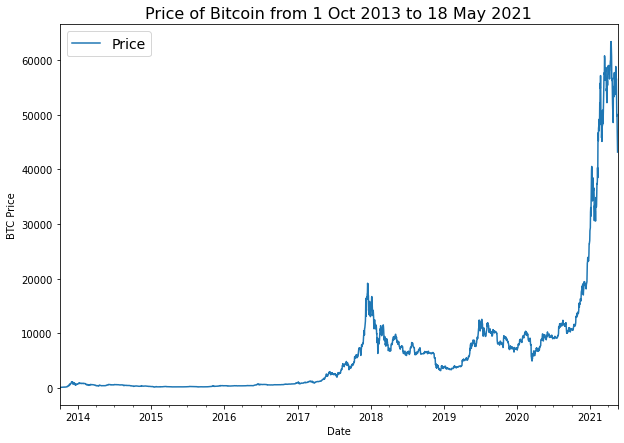

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Create train and test splits for time series

In [7]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [8]:
split_size = int(0.8 * len(bitcoin_prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

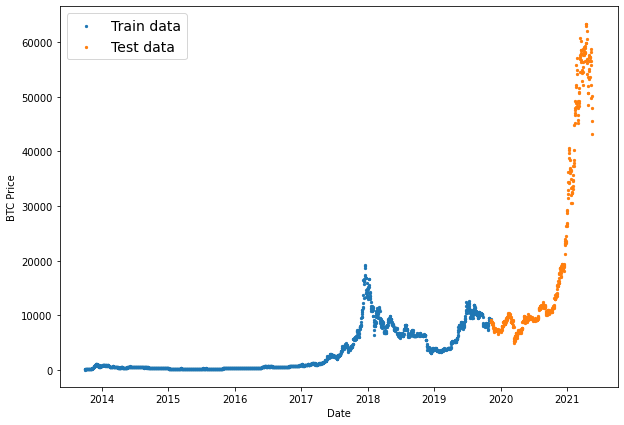

In [9]:
# Plot splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create plotting fucntion

In [10]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

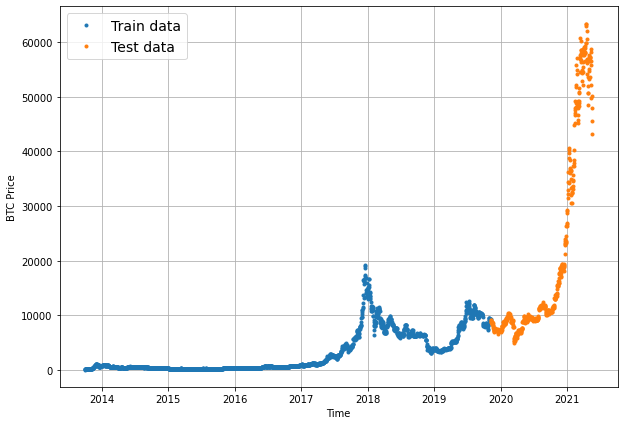

In [11]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model 0: Naive forcast model (baseline)

In [12]:
# Create a naïve forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:] 

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

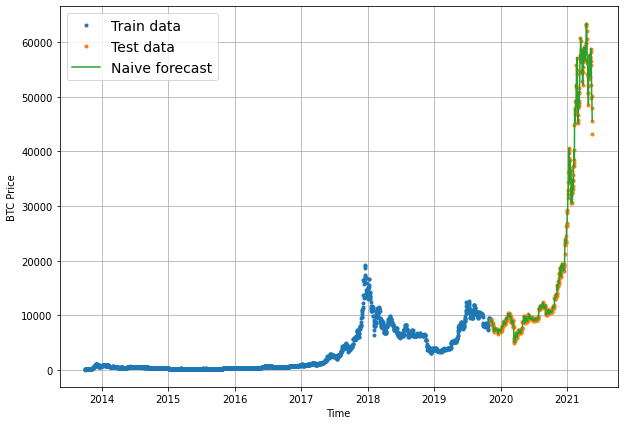

In [13]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

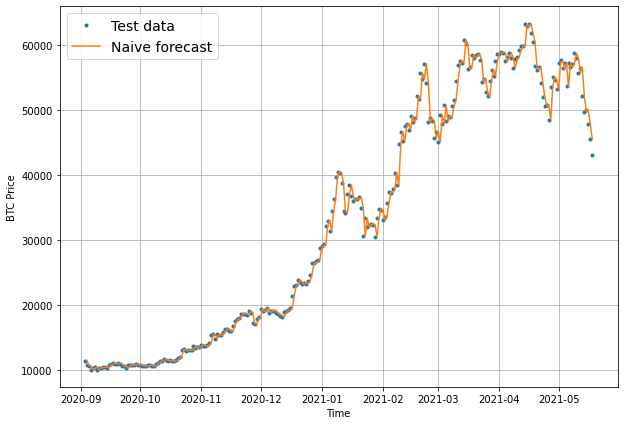

In [14]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

## Crreate a function that takes true and pred values and return evaluation metrics

In [15]:
import tensorflow as tf
import numpy as np

In [16]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [17]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


In [18]:
# test the funcion using model 0 results
model_0_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
model_0_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 567.9802,
 'rmse': 23.832336}

## Format data: window the dataset

In [19]:
# set global variables 
HORIZON = 1 
WINDOW_SIZE = 7

In [20]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [21]:
# create function to iew numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  turn an 1D array into a 2D array of sequential windows of window_size
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [22]:
# test the function
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [23]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


## Turning windows into training and test sets

In [24]:
# make train test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [25]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [26]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## make modeling checkpoint

In [27]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file
                                          

## Model 1: Dense model (window = 7, horizon = 1)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed for reproductability
tf.random.set_seed(42)

#construct model
model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 4s 110ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
Epoch 2/100
18/18 [==============================] - 1s 57ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9992 - val_mae: 1005.9992
Epoch 3/100
18/18 [==============================] - 1s 52ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2863 - val_mae: 923.2863
Epoch 4/100
18/18 [==============================] - 1s 68ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 1s 76ms/step - loss: 165.0895 - mae: 165.0895 - val_loss: 895.2236 - val_mae: 895.2236
Epoch 6/100
18/18 [==============================] - 1s 53ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1985 - val_mae: 855.1985
Epoch 7/100
18/18 [==============================] - 1s 56ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9167 - val_mae: 840.9166
Epoch 8/100
18/

In [29]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9752 - mae: 585.9752


[585.9752197265625, 585.9752197265625]

In [30]:
# Making forecasts with a model (on the test dataset)
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [31]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8801.184, 8714.926, 8972.654, 8760.343, 8676.047, 8679.056,
        8641.019, 8451.335, 8412.065, 8468.017], dtype=float32)>)

In [32]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 585.9753,
 'mape': 2.6149077,
 'mase': 1.0293963,
 'mse': 585.9753,
 'rmse': 24.206926}

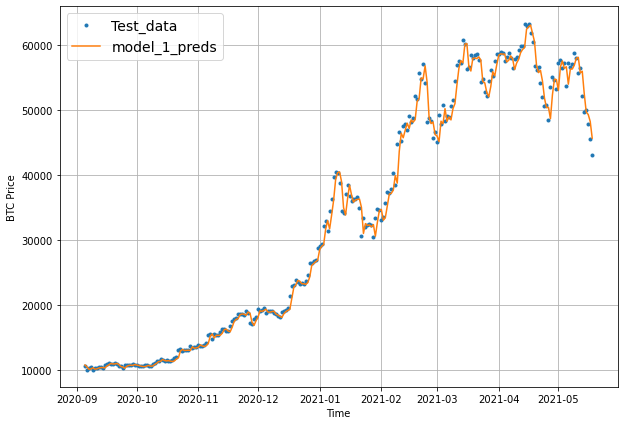

In [33]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [34]:
HORIZON = 1 
WINDOW_SIZE = 30

In [35]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [36]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [37]:
# set random seed for reproductability
tf.random.set_seed(42)

#construct model
model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

# compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [38]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9620 - mae: 608.9620


[608.9619750976562, 608.9619750976562]

In [39]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9620 - mae: 608.9620


[608.9619750976562, 608.9619750976562]

In [40]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [41]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.962,
 'mape': 2.769341,
 'mase': 1.0644715,
 'mse': 608.962,
 'rmse': 24.677155}

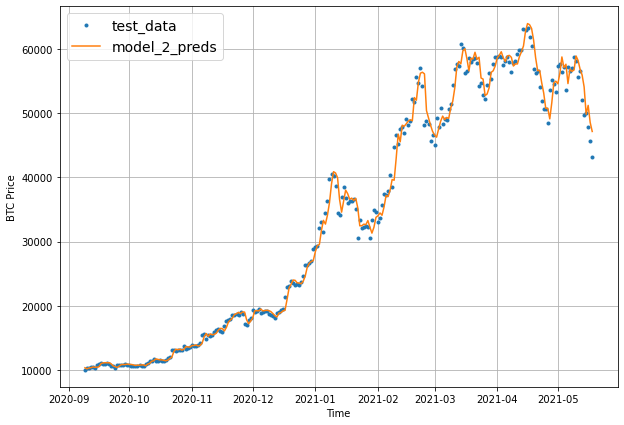

In [42]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

In [43]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [44]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [45]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [46]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1340.4274 - mae: 1340.4274


[1340.4273681640625, 1340.4273681640625]

In [47]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1234.8838 - mae: 1234.8838


[1234.8837890625, 1234.8837890625]

In [48]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9250.798 , 9279.124 , 9394.038 , 9400.203 , 9479.183 , 9375.264 ,
        9302.472 ],
       [8945.557 , 9029.439 , 9164.761 , 8997.948 , 9077.654 , 8971.883 ,
        9081.854 ],
       [8883.711 , 8987.258 , 9057.07  , 8901.714 , 9001.872 , 8817.509 ,
        8971.558 ],
       [9090.947 , 9014.501 , 9010.567 , 9096.448 , 9052.973 , 9016.151 ,
        9001.476 ],
       [9002.045 , 8972.497 , 8869.7705, 8980.389 , 9212.569 , 9072.293 ,
        8887.335 ]], dtype=float32)>

In [49]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  561.22516 ,   301.9714  ,   297.9477  ,   413.84305 ,
          445.20914 ,   540.59717 ,   527.2284  ,   441.84564 ,
          498.77365 ,   639.1921  ,   803.132   ,   731.72614 ,
          678.6172  ,   797.18567 ,   575.3339  ,   280.21136 ,
          239.9216  ,   246.152   ,   276.387   ,   285.75482 ,
          118.80413 ,   135.45549 ,   191.11852 ,   251.82576 ,
          170.28928 ,   154.20027 ,   107.244835,    97.66267 ,
          111.26409 ,   139.85393 ,   269.1739  ,   369.812   ,
          270.48096 ,   263.1211  ,   247.72252 ,   255.50523 ,
          298.48172 ,   245.26395 ,   243.13072 ,   255.7583  ,
          416.6257  ,   150.97021 ,    94.16581 ,   101.62012 ,
           93.76967 ,    86.75328 ,    73.27923 ,    79.04513 ,
           89.541084,    93.11977 ,   106.798546,   141.09578 ,
          178.73668 ,   145.46994 ,   256.4566  ,   392.8164  ,
          560.91174 ,   552.8188  ,   536.1548  ,   535.2687  ,
          448.70444 ,   267.23297

## Make our evaluation function work for larger horizons

In [50]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # account for different sized metrics
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae":mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [51]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1234.8837,
 'mape': 5.4874983,
 'mase': 2.1974063,
 'mse': 5393734.0,
 'rmse': 1419.1362}

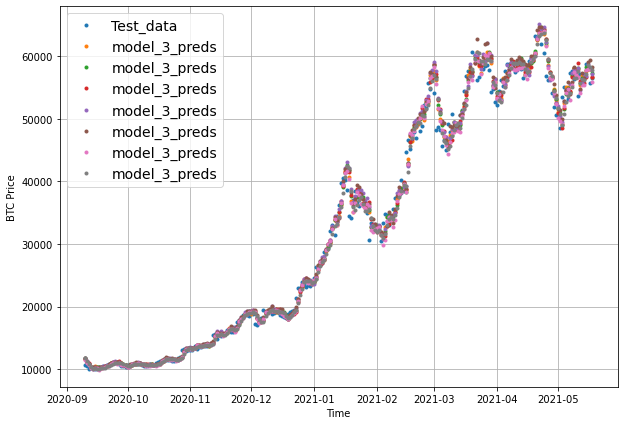

In [52]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

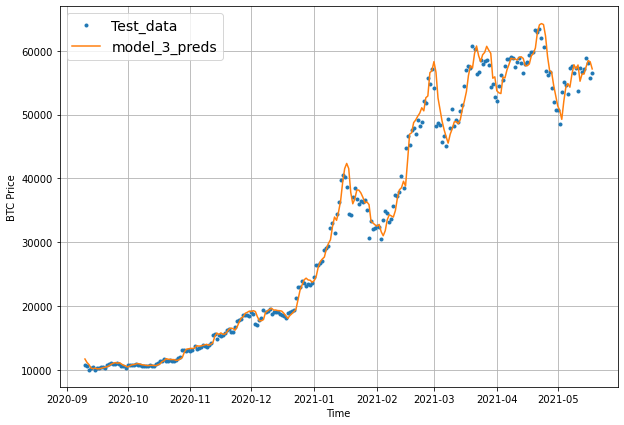

In [53]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Model 4: Conv1D

In [54]:
HORIZON = 1 
WINDOW_SIZE = 7 

In [55]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [56]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [57]:
tf.random.set_seed(42)

# create model
model_4 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                               layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 8s 46ms/step - loss: 1207.3817 - mae: 1207.3817 - val_loss: 2320.6216 - val_mae: 2320.6216
Epoch 2/100
18/18 [==============================] - 1s 38ms/step - loss: 316.2172 - mae: 316.2172 - val_loss: 1467.2802 - val_mae: 1467.2802
Epoch 3/100
18/18 [==============================] - 1s 51ms/step - loss: 192.6853 - mae: 192.6853 - val_loss: 1164.7075 - val_mae: 1164.7075
Epoch 4/100
18/18 [==============================] - 1s 39ms/step - loss: 177.3535 - mae: 177.3535 - val_loss: 981.6695 - val_mae: 981.6695
Epoch 5/100
18/18 [==============================] - 1s 38ms/step - loss: 172.3467 - mae: 172.3467 - val_loss: 960.8710 - val_mae: 960.8710
Epoch 6/100
18/18 [==============================] - 1s 38ms/step - loss: 171.9754 - mae: 171.9754 - val_loss: 950.2026 - val_mae: 950.2026
Epoch 7/100
18/18 [==============================] - 1s 84ms/step - loss: 167.1943 - mae: 167.1943 - val_loss: 943.2872 - val_mae: 943.2872
Epoch 8/100


In [58]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 10ms/step - loss: 570.8284 - mae: 570.8284


[570.8284301757812, 570.8284301757812]

In [60]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.465, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.668, 8494.839, 8435.317, 8492.115], dtype=float32)>

In [61]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.8284,
 'mape': 2.5593352,
 'mase': 1.0027875,
 'mse': 1176671.6,
 'rmse': 1084.745}

## Model 5: RNN (LSTM)

In [62]:
tf.random.set_seed(42)

# build an LSTM model
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 2534.5144 INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 125ms/step - loss: 2323.6077 - val_loss: 9222.6221
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 859.7301 INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 695.4739 - val_loss: 1486.0378
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 266.4731INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 237.3842 - val_loss: 1298.9087
Epoch 4/100
13/18 [====================>.........] - ETA: 0s - loss: 189.4989INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 113ms/step - loss: 181.9185 - val_loss: 966.6432
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 173.4023 - val_loss: 970.9296
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 173.3822 - val_loss: 981.0975
Epoch 7/100
13/18 [====================>.........] - ETA: 0s - loss: 182.3532INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 171.9762 - val_loss: 921.8434
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 166.3044INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 165.5515 - val_loss: 900.0497
Epoch 9/100
12/18 [===================>..........] - ETA: 0s - loss: 161.7419INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 101ms/step - loss: 160.4305 - val_loss: 853.6299
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 168.6475 - val_loss: 931.5431
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 169.2183 - val_loss: 926.0713
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 166.3748 - val_loss: 916.8346
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 166.8522 - val_loss: 909.6310
Epoch 14/100
18/18 [==============================] - 0s 6ms/step - loss: 161.6482 - val_loss: 866.7496
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 155.9960 - val_loss: 896.1780
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 159.4309 - val_loss: 882.4391
Epoch 17/100
18/18 [==============================] - 0s 8ms/step - loss: 157.7812 - val_loss: 956.9371
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 1

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 116ms/step - loss: 150.1062 - val_loss: 844.7767
Epoch 23/100
18/18 [==============================] - 0s 7ms/step - loss: 149.1968 - val_loss: 861.0685
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 147.1761 - val_loss: 848.1241
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 152.1306INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 145.5848 - val_loss: 840.6231
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 142.8045INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 96ms/step - loss: 145.0945 - val_loss: 813.1295
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 151.9896INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 117ms/step - loss: 143.2227 - val_loss: 805.5842
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 141.3780INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 141.6531 - val_loss: 785.5984
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 140.8680 - val_loss: 801.3979
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 141.3804 - val_loss: 791.8160
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 139.9352INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 138.0144 - val_loss: 768.1625
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 138.1926INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 135.9883 - val_loss: 764.0204
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 136.6867 - val_loss: 791.4828
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 142.0320INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 119ms/step - loss: 136.4118 - val_loss: 750.6531
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 133.7257 - val_loss: 754.5988
Epoch 36/100
13/18 [====================>.........] - ETA: 0s - loss: 134.6520INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 133.4312 - val_loss: 734.5640
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 131.2189 - val_loss: 747.5995
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 138.4018INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 97ms/step - loss: 129.7771 - val_loss: 718.2686
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 131.0688INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 117ms/step - loss: 129.4270 - val_loss: 716.9465
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 130.6303 - val_loss: 728.0188
Epoch 41/100
12/18 [===================>..........] - ETA: 0s - loss: 130.7772INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 127.6953 - val_loss: 701.7618
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 126.2242 - val_loss: 706.0325
Epoch 43/100
13/18 [====================>.........] - ETA: 0s - loss: 121.9465INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 125.7488 - val_loss: 693.8345
Epoch 44/100
13/18 [====================>.........] - ETA: 0s - loss: 122.2618INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 115ms/step - loss: 125.5652 - val_loss: 689.3698
Epoch 45/100
13/18 [====================>.........] - ETA: 0s - loss: 120.8933INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 123.4030 - val_loss: 682.0648
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 130.1366INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 124.5756 - val_loss: 679.0645
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 122.3864 - val_loss: 700.8399
Epoch 48/100
13/18 [====================>.........] - ETA: 0s - loss: 120.7901INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 122.4737 - val_loss: 676.0283
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 122.0582 - val_loss: 690.3026
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 124.1240 - val_loss: 714.4885
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 125.1230 - val_loss: 778.5692
Epoch 52/100
11/18 [=================>............] - ETA: 0s - loss: 131.4363INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 118ms/step - loss: 123.6763 - val_loss: 660.4346
Epoch 53/100
12/18 [===================>..........] - ETA: 0s - loss: 117.3057INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 119.8259 - val_loss: 659.2103
Epoch 54/100
12/18 [===================>..........] - ETA: 0s - loss: 117.4700INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 120.3732 - val_loss: 654.3164
Epoch 55/100
10/18 [===============>..............] - ETA: 0s - loss: 126.2897INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 115ms/step - loss: 118.6429 - val_loss: 648.6450
Epoch 56/100
18/18 [==============================] - ETA: 0s - loss: 120.1063INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 101ms/step - loss: 120.1063 - val_loss: 645.4896
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 123.7777 - val_loss: 680.8215
Epoch 58/100
13/18 [====================>.........] - ETA: 0s - loss: 119.8549INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 118.7787 - val_loss: 641.7518
Epoch 59/100
12/18 [===================>..........] - ETA: 0s - loss: 114.4179INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 117ms/step - loss: 117.9966 - val_loss: 641.0961
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3239 - val_loss: 643.4174
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 118.6151 - val_loss: 696.0721
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 122.4420 - val_loss: 749.9855
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 123.8672 - val_loss: 660.2910
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 117.0016 - val_loss: 687.4307
Epoch 65/100
12/18 [===================>..........] - ETA: 0s - loss: 121.8536INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 100ms/step - loss: 119.8755 - val_loss: 632.8752
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 117.1110 - val_loss: 640.7438
Epoch 67/100
12/18 [===================>..........] - ETA: 0s - loss: 114.8851INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 102ms/step - loss: 117.9292 - val_loss: 626.2725
Epoch 68/100
12/18 [===================>..........] - ETA: 0s - loss: 116.3970INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 117.1456 - val_loss: 625.1245
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 119.3027 - val_loss: 625.7104
Epoch 70/100
13/18 [====================>.........] - ETA: 0s - loss: 112.2845INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 121ms/step - loss: 114.9086 - val_loss: 621.8661
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 115.1822 - val_loss: 654.4707
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 119.3393 - val_loss: 632.7345
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 115.7310 - val_loss: 627.1373
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2199 - val_loss: 625.5247
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 115.5961 - val_loss: 647.6739
Epoch 76/100
10/18 [===============>..............] - ETA: 0s - loss: 116.9646INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 98ms/step - loss: 114.7675 - val_loss: 617.0222
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 116.8673 - val_loss: 666.9280
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 117.1996 - val_loss: 627.6133
Epoch 79/100
12/18 [===================>..........] - ETA: 0s - loss: 111.1984INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 101ms/step - loss: 113.5704 - val_loss: 611.2637
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2127 - val_loss: 621.4436
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3850 - val_loss: 631.9078
Epoch 82/100
11/18 [=================>............] - ETA: 0s - loss: 123.1307INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 118ms/step - loss: 116.0263 - val_loss: 610.8793
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 113.4978 - val_loss: 631.0351
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4766 - val_loss: 620.5226
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3218 - val_loss: 640.3288
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 115.0620 - val_loss: 614.5500
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 116.9279INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 112.4946 - val_loss: 609.2250
Epoch 88/100
11/18 [=================>............] - ETA: 0s - loss: 115.2020INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 112.1963 - val_loss: 603.8983
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 112.1124 - val_loss: 629.1746
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 116.6988 - val_loss: 645.2277
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 115.3321 - val_loss: 626.2292
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3265 - val_loss: 612.6552
Epoch 93/100
10/18 [===============>..............] - ETA: 0s - loss: 112.5304INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 113.0708 - val_loss: 599.9893
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2166 - val_loss: 600.3155
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 109.0319INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 118ms/step - loss: 111.1020 - val_loss: 598.2369
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3853 - val_loss: 605.4749
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.6455 - val_loss: 625.0032
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 112.1201 - val_loss: 600.1553
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9818 - val_loss: 598.9257
Epoch 100/100
12/18 [===================>..........] - ETA: 0s - loss: 120.7395INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 99ms/step - loss: 112.5498 - val_loss: 597.4623


In [63]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 597.4624


597.46240234375

In [64]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8992.637, 8824.648, 9010.125, 8848.681, 8743.077, 8789.642,
       8745.362, 8553.346, 8515.999, 8543.483], dtype=float32)>

In [65]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 597.46234,
 'mape': 2.6910973,
 'mase': 1.0495758,
 'mse': 1275416.0,
 'rmse': 1129.3431}

In [66]:
model_0_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 567.9802,
 'rmse': 23.832336}

## Make a multivariate time series

In [67]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [68]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [69]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


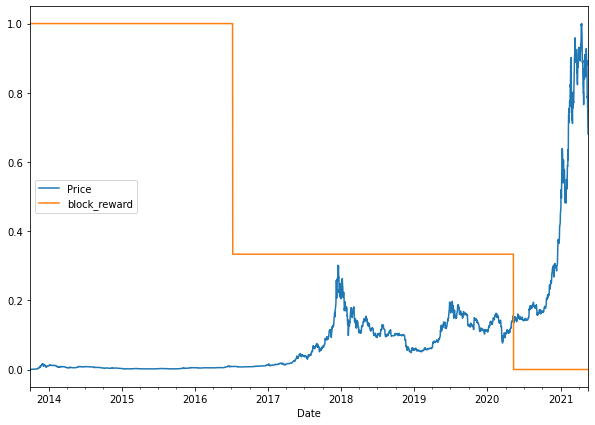

In [70]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

In [71]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [72]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [73]:
# create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [74]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [75]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [76]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


In [77]:
# load the best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 568.4492


568.44921875

In [78]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8813.428, 8767.833, 9045.073, 8723.28 , 8713.942, 8744.135,
       8651.524, 8490.181, 8448.834, 8518.018], dtype=float32)>

In [79]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.4492,
 'mape': 2.5558872,
 'mase': 0.9986078,
 'mse': 1162442.2,
 'rmse': 1078.1661}

In [80]:
model_6_results

{'mae': 568.4492,
 'mape': 2.5558872,
 'mase': 0.9986078,
 'mse': 1162442.2,
 'rmse': 1078.1661}

## Model 7: N-Beats algorithm

### build and test the N-Beats block layer

In [81]:
# create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # output of block
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [82]:
# test NBeatsBlock class
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [83]:
# create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [84]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.4634871   0.10944445 -0.4335533   0.9360242  -0.35703525 -0.17927599
 -0.3404836 ]
Forecast: -0.43979012966156006


### Preparing data for the N-BEATS algorithm using `tf.data`

In [85]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [86]:
# create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [87]:
# add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [88]:
# make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

In [89]:
# make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [90]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Set up hyperparameters for N-BEATS algorithm

In [91]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Get ready for residual connections

In [92]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Build, compile and fit the N-BEATS algorithm

In [93]:
tf.random.set_seed(42)

# setup N-Beats Block layer
n_beats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

# create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# create initial backcast and forecast input
backcast, forcast = n_beats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=['mae', 'mse'])

# fit the model
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.


In [94]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 24ms/step - loss: 979368.0625 - mae: 979368.0625 - mse: 1693616963584.0000


[979368.0625, 979368.0625, 1693616963584.0]

In [95]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-442245., -434052., -429180., -434520., -427207., -414812.,
       -426345., -417065., -411583., -410959.], dtype=float32)>

In [96]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 979368.06,
 'mape': 4887.2837,
 'mase': 1720.4784,
 'mse': 1693617000000.0,
 'rmse': 1301390.4}

## Model 8: Creating an ensemble

In [97]:
HORIZON, WINDOW_SIZE

(1, 7)

### Construct and fit and ensemble of models

In [103]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=['mae','mse','mape']):
  """
  retrun a list of num_iter models each trained on MAE, MSE, MAPE loss
  """
  # make an empty list of trained ensemble models
  ensemble_models = []

  # create num_iter number of models per loss function
  for i in range(num_iter):
    # build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # construct a simple model
      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                             
      ])

      # compile the simple model
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # append fitted model to list of ensemble models
      ensemble_models.append(model)
  
  return ensemble_models



In [104]:
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00987: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00640: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00756: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00856: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00999: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00425: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 0

### Make predictions with an ensemble model

In [105]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [106]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8778.355,  8773.731,  9047.666, ..., 50317.797, 49524.207,
        46493.65 ],
       [ 8766.593,  8744.877,  9057.469, ..., 49413.38 , 48507.145,
        45347.375],
       [ 8745.423,  8733.032,  9101.387, ..., 49267.17 , 47660.42 ,
        45370.055],
       ...,
       [ 8896.456,  8757.007,  9032.771, ..., 49539.234, 49301.14 ,
        46366.22 ],
       [ 8723.885,  8800.434,  9099.885, ..., 49565.8  , 48506.27 ,
        45015.38 ],
       [ 8819.857,  8765.874,  9047.748, ..., 49759.977, 48066.59 ,
        45878.656]], dtype=float32)>

In [107]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 566.5914,
 'mape': 2.5758984,
 'mase': 0.9953441,
 'mse': 1141066.6,
 'rmse': 1068.2072}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

In [108]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

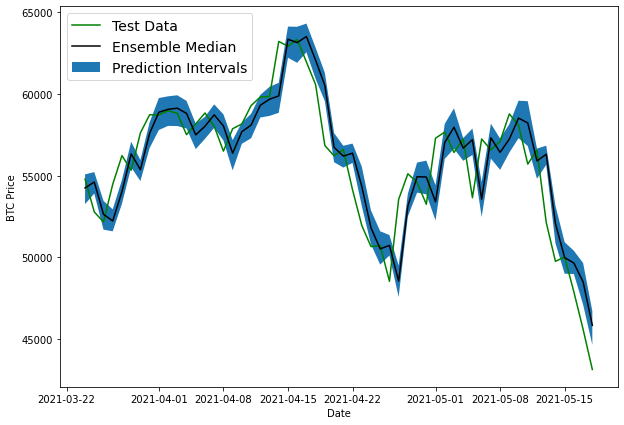

In [109]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Train a model on the full historical data to make predictions into future

In [111]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [112]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() 
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [113]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [114]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) 

### Make prediction into the future

In [115]:
INTO_FUTURE = 14 

In [116]:
# Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.  
  """
  # make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    # predict on last window then append it again
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # append predictions to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [147]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96875

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96875   ] -> Prediction: 48137.203125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96875    48137.203125  ] -> Prediction: 47880.6328125

Predicting on: 
 [45604.61575361 43144.47129086 55764.46484375 50985.9453125
 48522.96875    48137.203125   47880.6328125 ] -> Prediction: 46879.71484375

Predicting on: 
 [43144.47129086 55764.46484375 50985.9453125  48522.968

In [148]:
future_forecast[:10]

[55764.465,
 50985.945,
 48522.97,
 48137.203,
 47880.633,
 46879.715,
 48227.598,
 53963.69,
 49685.56,
 47596.176]

### Plot future forecasts

In [149]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")  

In [150]:
# last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [151]:
# get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [152]:
# insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, bitcoin_prices['Price'].to_list()[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.465, 50985.945, 48522.97 , 48137.203, 47880.633,
        46879.715, 48227.598, 53963.69 , 49685.56 , 47596.176, 48114.426,
        48808.004, 48623.848, 50178.723], dtype=float32))

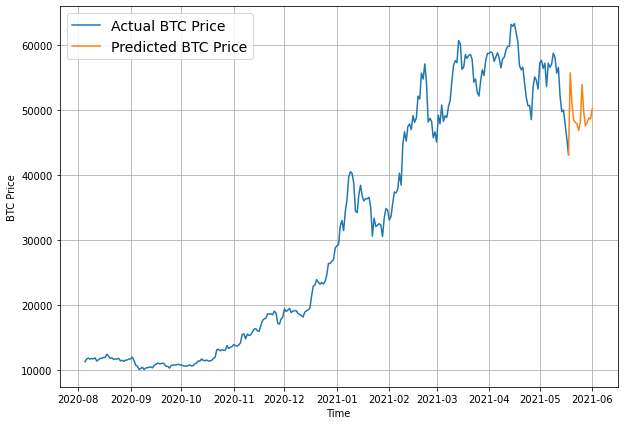

In [153]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, bitcoin_prices['Price'].to_list(), start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Compare all model results

In [159]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": model_0_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,5.679802e+02,2.383234e+01,2.516525,0.999570
model_1_dense_w7_h1,585.975281,5.859753e+02,2.420693e+01,2.614908,1.029396
model_2_dense_w30_h1,608.961975,6.089620e+02,2.467715e+01,2.769341,1.064471
model_3_dense_w30_h7,1234.883667,5.393734e+06,1.419136e+03,5.487498,2.197406
model_4_CONV1D,570.828430,1.176672e+06,1.084745e+03,2.559335,1.002787
model_5_LSTM,597.462341,1.275416e+06,1.129343e+03,2.691097,1.049576
model_6_multivariate,568.449219,1.162442e+06,1.078166e+03,2.555887,0.998608
model_8_NBEATs,979368.062500,1.693617e+12,1.301390e+06,4887.283691,1720.478394
model_9_ensemble,566.591370,1.141067e+06,1.068207e+03,2.575898,0.995344
